# Predicting income earnings higher than $50K with the census Data set:                   Olufemi Obembe Dec. 2019

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from sklearn_pandas import DataFrameMapper
%matplotlib inline

In [2]:
header = ['age','workclass','fnlwgt','education','education_num','marital','occupation','relationship','race','sex','capital_gain','capital_loss','hr_per_week','country','income']
cdfr = pd.read_csv('census.txt',names=header, na_values=[' ?'])

In [3]:
#Take a look at the data

cdfr.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
cdfr.shape

(48842, 15)

In [5]:
cdfr.dtypes

age               int64
workclass        object
fnlwgt            int64
education        object
education_num     int64
marital          object
occupation       object
relationship     object
race             object
sex              object
capital_gain      int64
capital_loss      int64
hr_per_week       int64
country          object
income           object
dtype: object

In [6]:
#Check for missing values

msv = round(cdfr.isnull().sum(),2)
msv

age                 0
workclass        2799
fnlwgt              0
education           0
education_num       0
marital             0
occupation       2809
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hr_per_week         0
country           857
income              0
dtype: int64

There are three columns with missing values: workclass, occupation and country.  We shall examine the three columns closely to see how best to fill the missing values.

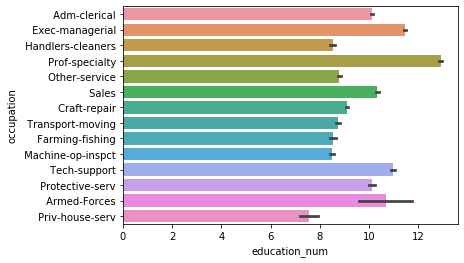

In [7]:
#Let's examine the relationship between occupation and education_num to see if there is any pattern

sns.barplot(cdfr['education_num'],cdfr['occupation'])

From the above distribution, it seems that people in 'Exec-managerial' and 'Prof-specialty' have more than 11 years of schooling, it may be reasonable therefore to assume that people with more than 11 years of schooling but with missing occupational data should be categorized either as Exec-managerial or Prof-specialty.  In any case, these two categories can as well be merged to form a high-skilled group.  

There is a second category comprising 'Adm-clerical', 'sales', 'Tech-support', and 'Armed-Forces' with around 10 years of schooling which also can be categorized as medium skill.

The last set of occupational classes which include; 'handlers-cleaners', other-service, craft-repairer, Transport-moving, Farming-fishing,protective-serv, priv-house-serv, all have number of years of education that are less than 10 years, which all can be classified as Low-skilled jobs.

Given the above observations, we can use the age column to create another variable to replace 'occupation' with 2799 missing columns.

In [8]:
#Let's examine the workclass column.  We may have to examine the relationship between workclass and sex, race

#workclass and sex

cdfr_percent = pd.crosstab(cdfr.sex,cdfr.workclass,normalize='index').rename_axis(None)
cdfr_percent *=100
cdfr_percent

workclass,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
Female,3.029085,8.430505,0.020105,77.730867,1.414020,4.215253,5.113256,0.046911
Male,3.148999,6.034510,0.022493,71.678288,4.768484,10.388484,3.913756,0.044986


Looking at the distribution of workclass by gender, there seems to be no over or under concentration of gender in any of the workclasses except 'Self-empl-not-inc'.  It will be naive for us to try and fix the missing values with values predicted from gender.

In [9]:
#workclass and race

cdf_percent = pd.crosstab(cdfr.race,cdfr.workclass,normalize='index').rename_axis(None)
cdf_percent *=100
cdf_percent

workclass,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
Amer-Indian-Eskimo,7.586207,14.942529,0.000000,63.908046,0.459770,7.816092,5.287356,0.000000
Asian-Pac-Islander,4.497540,4.146170,0.000000,73.295854,4.497540,7.027407,6.465214,0.070274
Black,5.849966,10.025235,0.068823,74.535444,0.871760,3.119982,5.505850,0.022941
Other,2.933333,4.266667,0.000000,83.200000,1.600000,4.266667,3.733333,0.000000
White,2.709691,6.486528,0.017744,73.569745,4.017642,9.064409,4.086081,0.048161


Analysis of the workclass and race also seems to suggest that there is no clear-cut over or underdistribution of any race in the workclass category.

From our perspective, the two variables that could influence the distribution of workclass which are gender and race seems to be very weak.  

We may have no option than to delete all the rows with missing variables in workclass.

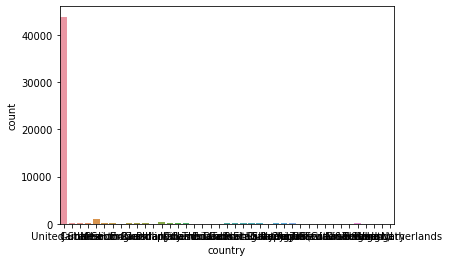

In [10]:
#Country analysis

sns.countplot(cdfr['country'])

From the distribution of countries, United States is the most dominant country in the group with 43,800 respondents, it may be a good idea to also delete the missing values from this column.

In [11]:
#Before proceeding to implement our observations above, lets try and check for duplicate values in the dataset
cdfr.duplicated().sum()


52

In [12]:
#Lets drop the duplicates and store the new value in cdfdt

cdfdt = cdfr.drop_duplicates()

In [13]:
cdfdt.shape

(48790, 15)

We have reomved 50 cases of duplicated values from the dataset.  We can go further to implement our missing values strategies.

In [14]:
pd.set_option('chained',None)

In [15]:
#For occupation, we create another variable from education_num and categorize them into 3:\
#HighSkilled (>11 yrs of education), MediumSkilled (10-11 years of education) and LowSkilled(<10 years of education)\
#based on our initial findings from the distribution.  

bins = [0,9,11,16]
labels = ['Lowskl','mediumskl','Highskl']
cdfdt['occup']=pd.cut(cdfdt['education_num'],bins,labels=labels)

Given that a new variable 'occup' has been created to replace occupation that contains several missing values, and given that we've resolved to delete rows of country and workclass with missing values, the next thing is to inspect our other variables and see how we can reconstruct the features to make more meaningful analysis.

In [16]:
#Education feature analysis and reconstruction:

cdfdt['education'].value_counts()

 HS-grad         15770
 Some-college    10863
 Bachelors        8013
 Masters          2656
 Assoc-voc        2060
 11th             1812
 Assoc-acdm       1601
 10th             1389
 7th-8th           954
 Prof-school       834
 9th               756
 12th              655
 Doctorate         594
 5th-6th           507
 1st-4th           245
 Preschool          81
Name: education, dtype: int64

In [17]:
#we can recategorize education variable based on 'Post graduate','college','below college'

def educ(x):
    if re.search('Doctorate',x):
        return 'Post_Graduate'
    elif re.search('Masters',x):
        return 'Post_Graduate'
    elif re.search('Bachelors',x):
        return 'Graduate'
    else:
        return 'Below_College'

In [18]:
import re

In [19]:
cdfdt['edu_cat']=cdfdt.education.apply(lambda x: x.strip()).apply(lambda x: educ(x))

In [20]:
cdfdt['edu_cat'].value_counts()

Below_College    37527
Graduate          8013
Post_Graduate     3250
Name: edu_cat, dtype: int64

In [21]:
#Similarly, let's examine marital attributes:

cdfdt['marital'].value_counts()

 Married-civ-spouse       22366
 Never-married            16082
 Divorced                  6630
 Separated                 1530
 Widowed                   1518
 Married-spouse-absent      627
 Married-AF-spouse           37
Name: marital, dtype: int64

In [22]:
#We can categorize marital as 'married','never married', and 'single'. 

def marr(x):
    if re.search('Married-civ-spouse',x):
        return 'married'
    elif re.search('Married-AF-spouse',x):
        return 'married'
    elif re.search('Never-married',x):
        return 'Nmarried'
    else:
        return 'single'

In [23]:
cdfdt['marital_stats']=cdfdt.marital.apply(lambda x: x.strip()).apply(lambda x: marr(x))

In [24]:
cdfdt['marital_stats'].value_counts()

married     22403
Nmarried    16082
single      10305
Name: marital_stats, dtype: int64

Having recategorized marital status into 3 groups, we shall also look at 'relationship' attribute and fine-tuned it.

In [25]:
cdfdt['relationship'].value_counts()

 Husband           19703
 Not-in-family     12557
 Own-child          7569
 Unmarried          5124
 Wife               2331
 Other-relative     1506
Name: relationship, dtype: int64

In [26]:
#From the distribution of 'relationship', we can group them into two, 
#i.e. 'within family' members and 'outside family' members

def rel(x):
    if re.search('Husband',x):
        return 'family'
    elif re.search('Wife',x):
        return 'family'
    elif re.search('Own-child',x):
        return 'family'
    else:
        return 'others'

In [27]:
cdfdt['rel_cat']=cdfdt.relationship.apply(lambda x: x.strip()).apply(lambda x: rel(x))

In [28]:
cdfdt['rel_cat'].value_counts()

family    29603
others    19187
Name: rel_cat, dtype: int64

In [29]:
#Let's check for race categorization

cdfdt['race'].value_counts()

 White                 41714
 Black                  4683
 Asian-Pac-Islander     1517
 Amer-Indian-Eskimo      470
 Other                   406
Name: race, dtype: int64

In [30]:
#We can leave race as it is.

The country variable can as well be partitioned into two:  United States and Others because most of the respondents (about 90%) are from the United States.

In [31]:
cdfdt['country']=cdfdt['country'].astype('str')

In [32]:
def Con(x):
    if re.search('United-States',x):
        return 'United_States'
    else:
        return 'other_countries'
    
cdfdt['country_cat']=cdfdt.country.apply(lambda x: x.strip()).apply(lambda x: Con(x))
cdfdt['country_cat'].value_counts()

United_States      43792
other_countries     4998
Name: country_cat, dtype: int64

# FEATURE SELECTION

In [33]:
cdfdt.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country,income,occup,edu_cat,marital_stats,rel_cat,country_cat
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Highskl,Graduate,Nmarried,others,United_States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,Highskl,Graduate,married,family,United_States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,Lowskl,Below_College,single,others,United_States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,Lowskl,Below_College,married,family,United_States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,Highskl,Graduate,married,family,other_countries


In [34]:
#lets check workclass for possible recategorization

cdfdt['workclass'].value_counts()

 Private             33860
 Self-emp-not-inc     3861
 Local-gov            3136
 State-gov            1981
 Self-emp-inc         1694
 Federal-gov          1432
 Without-pay            21
 Never-worked           10
Name: workclass, dtype: int64

In [35]:
#we can partition workclass into 3, 'Private','government','unemployed'

def wkls(x):
    if re.search('Private',x):
        return 'Private'
    elif re.search('Self-emp-not-inc',x):
        return 'SelfEmp'
    elif re.search('Self-emp-inc',x):
        return 'SelfEmp'
    elif re.search('Local-gov',x):
        return 'govt'
    elif re.search('State-gov',x):
        return 'govt'
    elif re.search('Federal-gov',x):
        return 'govt'
    else:
        return 'nojob'

In [36]:
cdfdt['workclass']=cdfdt['workclass'].astype('str')

In [37]:
cdfdt['wkclass']=cdfdt.workclass.apply(lambda x: x.strip()).apply(lambda x: wkls(x))

In [38]:
cdfdt['workclass']=cdfdt['workclass'].astype('str')

In [39]:
cdfdt['wkclass'].value_counts()

Private    33860
govt        6549
SelfEmp     5555
nojob       2826
Name: wkclass, dtype: int64

In [40]:
#Feature Selection for analysis

cdfdt.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hr_per_week', 'country', 'income', 'occup', 'edu_cat',
       'marital_stats', 'rel_cat', 'country_cat', 'wkclass'],
      dtype='object')

In [41]:
cdfdat = cdfdt[['age','fnlwgt','education_num','capital_gain','capital_loss','hr_per_week','race','sex','occupation','workclass','country','occup','edu_cat','marital_stats','rel_cat','country_cat','wkclass','income']]

In [42]:
cdfdat.isnull().sum()

age                 0
fnlwgt              0
education_num       0
capital_gain        0
capital_loss        0
hr_per_week         0
race                0
sex                 0
occupation       2805
workclass           0
country             0
occup               0
edu_cat             0
marital_stats       0
rel_cat             0
country_cat         0
wkclass             0
income              0
dtype: int64

In [43]:
cdfdat

,age,fnlwgt,education_num,capital_gain,capital_loss,hr_per_week,race,sex,occupation,workclass,country,occup,edu_cat,marital_stats,rel_cat,country_cat,wkclass,income
0,39,77516,13,2174,0,40,White,Male,Adm-clerical,State-gov,United-States,Highskl,Graduate,Nmarried,others,United_States,govt,<=50K
1,50,83311,13,0,0,13,White,Male,Exec-managerial,Self-emp-not-inc,United-States,Highskl,Graduate,married,family,United_States,SelfEmp,<=50K
2,38,215646,9,0,0,40,White,Male,Handlers-cleaners,Private,United-States,Lowskl,Below_College,single,others,United_States,Private,<=50K
3,53,234721,7,0,0,40,Black,Male,Handlers-cleaners,Private,United-States,Lowskl,Below_College,married,family,United_States,Private,<=50K
4,28,338409,13,0,0,40,Black,Female,Prof-specialty,Private,Cuba,Highskl,Graduate,married,family,other_countries,Private,<=50K
5,37,284582,14,0,0,40,White,Female,Exec-managerial,Private,United-States,Highskl,Post_Graduate,married,family,United_States,Private,<=50K
6,49,160187,5,0,0,16,Black,Female,Other-service,Private,Jamaica,Lowskl,Below_College,single,others,other_countries,Private,<=50K
7,52,209642,9,0,0,45,White,Male,Exec-managerial,Self-emp-not-inc,United-States,Lowskl,Below_College,married,family,United_States,SelfEmp,>50K
8,31,45781,14,14084,0,50,White,Female,Prof-specialty,Private,United-States,Highskl,Post_Graduate,Nmarried,others,United_States,Private,>50K
9,42,159449,13,5178,0,40,White,Male,Exec-managerial,Private,United-States,Highskl,Graduate,married,family,United_States,Private,>50K


In [44]:
cdfdat['workclass']=cdfdat['workclass'].astype('object')

Age distribution by groups have some important implications for earnings.  Infromation from Indexmundi:  https://www.indexmundi.com/united_states/age_structure.html:  shows that age can be categorized as children (0-15), early working age (15-24), prime working age (25-54), mature working age (55-64), and elderly (>65).  On the basis of this categorization, we shall be bin the age column to provide more insight into our analysis.

In [45]:
#Create bins for age

bins = [0,24,54,64,90]
labels = ['early_wa','prime_wa','mature_wa','elderly']

cdfdat['age_cat']=pd.cut(cdfdat['age'],bins,labels=labels)

In [46]:
cdfdat['age_cat'].value_counts()

prime_wa     33513
early_wa      8409
mature_wa     4782
elderly       2086
Name: age_cat, dtype: int64

Having performed the necessary engineering on the categorical varibales, we shall take a look at the continous variables to examine their distribution for possible transformation.

In [47]:
cdfdat.dtypes

age                 int64
fnlwgt              int64
education_num       int64
capital_gain        int64
capital_loss        int64
hr_per_week         int64
race               object
sex                object
occupation         object
workclass          object
country            object
occup            category
edu_cat            object
marital_stats      object
rel_cat            object
country_cat        object
wkclass            object
income             object
age_cat          category
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029E4DEFBE10>,
      dtype=object)

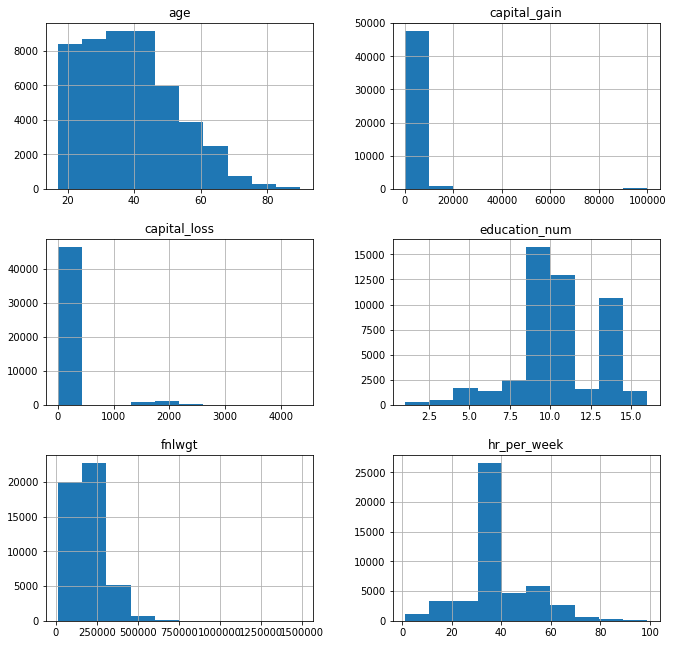

In [48]:
cdfdat[cdfdat.dtypes[(cdfdat.dtypes=='int64')].index.values].hist(figsize=[11,11])

From the above distribution of the variables, all the data shows some level of skewness which makes them to deviate from normal distribution.  We shall apply transformation on the numeric values to reduced the level of skewness.

We shall apply a box-cox transformation.  Box-cox provides a better way for data transformation becaue the alternative methods--square root, cube croot, log, all requires some level of random trials for appropropriate method.

In [49]:
#Box-cox transformation

from scipy import stats
from scipy.stats import boxcox

transform = np.asarray(cdfdat[['age']].values)
cdfdt = stats.boxcox(transform)[0]

In [50]:
cdfdat_transformed = cdfdat.copy()
cdfdat_transformed['capgain']=boxcox(cdfdat_transformed['capital_gain']+1)[0]
cdfdat_transformed['edu_num']=boxcox(cdfdat_transformed['education_num']+1)[0]
cdfdat_transformed['fnlw_tr']=boxcox(cdfdat_transformed['fnlwgt']+1)[0]
cdfdat_transformed['hr_work']=boxcox(cdfdat_transformed['hr_per_week']+1)[0]
cdfdat_transformed['caploss']=boxcox(cdfdat['capital_loss']+1)[0]
cdfdat_transformed['age_tr']=boxcox(cdfdat['age']+1)[0]

In [51]:
cdfdat1 = cdfdat_transformed

In [52]:
cdfdat1.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hr_per_week,race,sex,occupation,workclass,...,country_cat,wkclass,income,age_cat,capgain,edu_num,fnlw_tr,hr_work,caploss,age_tr
0,39,77516,13,2174,0,40,White,Male,Adm-clerical,State-gov,...,United_States,govt,<=50K,prime_wa,0.72941,25.763456,260.000052,39.586258,0.0,4.986548
1,50,83311,13,0,0,13,White,Male,Exec-managerial,Self-emp-not-inc,...,United_States,SelfEmp,<=50K,prime_wa,0.00000,25.763456,268.009596,12.911582,0.0,5.426726
2,38,215646,9,0,0,40,White,Male,Handlers-cleaners,Private,...,United_States,Private,<=50K,prime_wa,0.00000,16.045933,399.650164,39.586258,0.0,4.941629
3,53,234721,7,0,0,40,Black,Male,Handlers-cleaners,Private,...,United_States,Private,<=50K,prime_wa,0.00000,11.659602,414.116461,39.586258,0.0,5.532734
4,28,338409,13,0,0,40,Black,Female,Prof-specialty,Private,...,other_countries,Private,<=50K,prime_wa,0.00000,25.763456,482.774207,39.586258,0.0,4.428961


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029E4DBF7E10>,
      dtype=object)

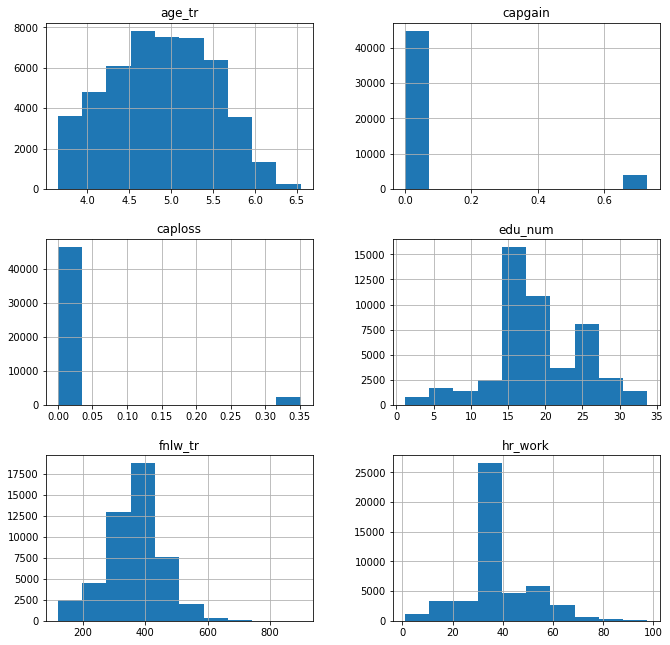

In [53]:
cdfdat1[['capgain','edu_num','fnlw_tr','hr_work','caploss','age_tr']].hist(figsize=[11,11])

The distribution above has shown some level of improvement towards normal distribution except for capital gain and capital loss

# Bivariate Analysis

Lets do some bivariate analysis to examine the weight of the covariates on the outcome variable.  We need however to transform the outcome variable attributes from <=50, and >50 to numeric variables.

In [54]:
cdfdat1['inc']=cdfdat1['income'].astype('category')

In [55]:
cdfdat1['inc']=cdfdat1['inc'].cat.codes

In [56]:
cdfdat1.columns

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hr_per_week', 'race', 'sex', 'occupation', 'workclass', 'country',
       'occup', 'edu_cat', 'marital_stats', 'rel_cat', 'country_cat',
       'wkclass', 'income', 'age_cat', 'capgain', 'edu_num', 'fnlw_tr',
       'hr_work', 'caploss', 'age_tr', 'inc'],
      dtype='object')

Distribution of Higher income by Gender

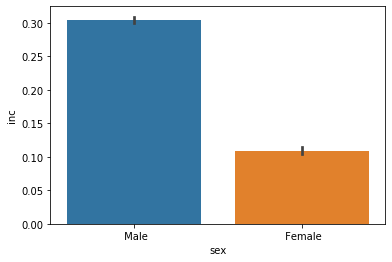

In [57]:
sns.barplot(cdfdat1['sex'],cdfdat1['inc'])

The distribution of higher income by gender shows that 30% of males have income higher than 50K compared to 10% of thier female counterpart.

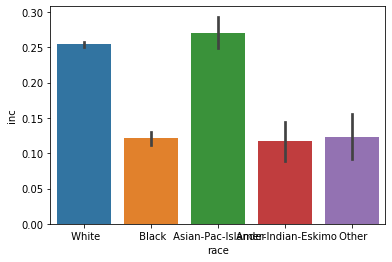

In [58]:
sns.barplot(cdfdat1['race'],cdfdat1['inc'])

The distribution of higher income by race shows that the Asian-Pac- seems to have the highest distribution of peple with income greater than 50K, however, the level of uncertainty around this distribution is much higher compared to those in the white category, which has a very close distribution with Asian-Pac.  The other race seems to suggest that about 10% of them earns income higher than 50K.

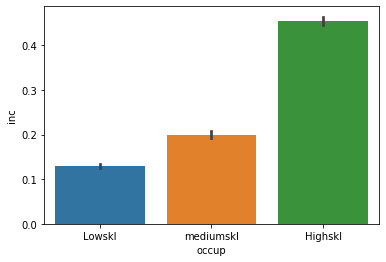

In [59]:
sns.barplot(cdfdat1['occup'],cdfdat1['inc'])

The skill level seems to provide a very good predictor of earnings higher than 50K, those with highest number of years of education which were classified as highskill has over 40% of them earning more than 50K.

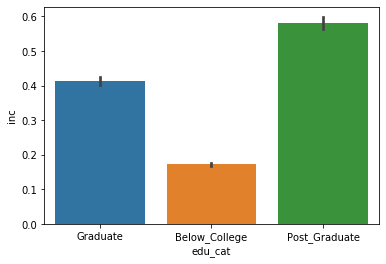

In [60]:
sns.barplot(cdfdat1['edu_cat'],cdfdat1['inc'])

Educational category also seems to provide a good predictor of eanrings higher than 50K.  Over 50% of those with higher income have a postgradaute degree, while it is 40% for those with college degree and about 15% for those with lower than college degree.

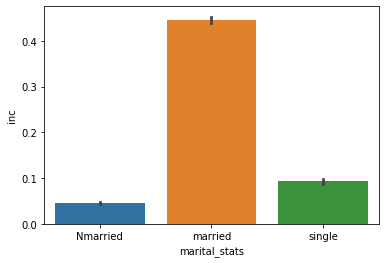

In [61]:
sns.barplot(cdfdat1['marital_stats'],cdfdat1['inc'])

The distributionof marital status vs earnings higher than 50K seems to suggest that being married is a good predictor of earnings higher than 50K.  Over 50% of married people earns more than 50K, while only very few (less than 10%) of those never married and single have income lower than 50K.

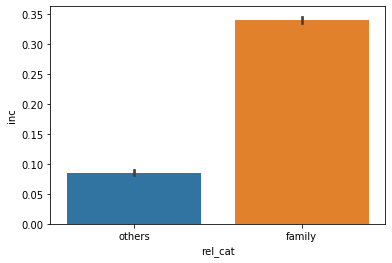

In [62]:
sns.barplot(cdfdat1['rel_cat'],cdfdat1['inc'])

those with family members also provide some indication of earnings of income higher than 50K.  Over 30% of them earns more than 50K as against less than 10% of those with non-family members.

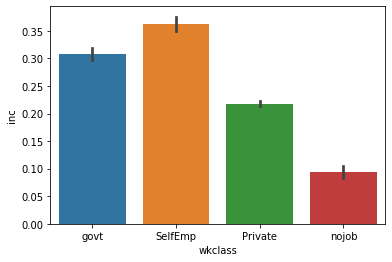

In [63]:
sns.barplot(cdfdat1['wkclass'],cdfdat1['inc'])

The distribution of earnings by work categories seems to be less diversed compared to previous variables examined.  However, about 35% of those in self-employment earns more than 50K compared to those 30% working for governemnt and 20% working for private firms.

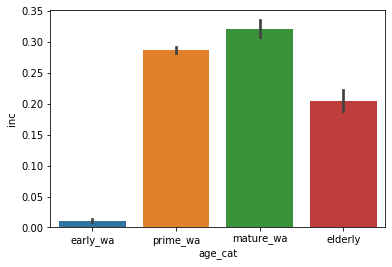

In [64]:
sns.barplot(cdfdat1['age_cat'],cdfdat1['inc'])

Earnings above 50K seems to be a bit evenly distributed.  Even though those in mature working age (mature_wa) bracket have higer proprotion of earnings greater than 50k, this may not be significantly different from those in prime working age and the elderly. However, literature suggests that interacting this variable with sex, marital status may produce some significant effects.

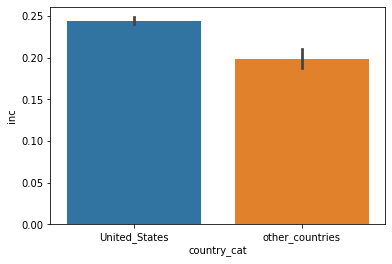

In [65]:
sns.barplot(cdfdat1['country_cat'],cdfdat1['inc'])

The earnings by country of origin of the respondents shows that a higher proportion (24%) of those with American origin earns more than 50K versus those from other origin (20%)

In [66]:
cdfdat1.columns

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hr_per_week', 'race', 'sex', 'occupation', 'workclass', 'country',
       'occup', 'edu_cat', 'marital_stats', 'rel_cat', 'country_cat',
       'wkclass', 'income', 'age_cat', 'capgain', 'edu_num', 'fnlw_tr',
       'hr_work', 'caploss', 'age_tr', 'inc'],
      dtype='object')

In [67]:
#Feature Selection:  Given the extra variable created, we need to select features that would be used for our prediction.

cdf_dat = cdfdat1[['age','sex','edu_num','race','occup','edu_cat','hr_per_week','marital_stats','rel_cat','country_cat','wkclass','age_cat','capgain','caploss','fnlw_tr','hr_work','age_tr','inc']]

In [68]:
cdf_dat.head()

,age,sex,edu_num,race,occup,edu_cat,hr_per_week,marital_stats,rel_cat,country_cat,wkclass,age_cat,capgain,caploss,fnlw_tr,hr_work,age_tr,inc
0,39,Male,25.763456,White,Highskl,Graduate,40,Nmarried,others,United_States,govt,prime_wa,0.72941,0.0,260.000052,39.586258,4.986548,0
1,50,Male,25.763456,White,Highskl,Graduate,13,married,family,United_States,SelfEmp,prime_wa,0.00000,0.0,268.009596,12.911582,5.426726,0
2,38,Male,16.045933,White,Lowskl,Below_College,40,single,others,United_States,Private,prime_wa,0.00000,0.0,399.650164,39.586258,4.941629,0
3,53,Male,11.659602,Black,Lowskl,Below_College,40,married,family,United_States,Private,prime_wa,0.00000,0.0,414.116461,39.586258,5.532734,0
4,28,Female,25.763456,Black,Highskl,Graduate,40,married,family,other_countries,Private,prime_wa,0.00000,0.0,482.774207,39.586258,4.428961,0


Our dataframe for analysis is displayed above.  However, we need to reduce all the variables to numeric so that we can apply machine learning on them.  For this purpose, we make use of the DataFrameMapper from sklearn pandas.

In [69]:
from sklearn_pandas import DataFrameMapper

Two sets of datasets are created (dat1 and dat2).  For dat1, age and education were measured in continous terms while in dat2, age and education were measured in categorical terms.  dat1 is used in this analysis.

In [70]:
dat1 = cdf_dat[['age_tr','edu_num','sex','race','occup','marital_stats','rel_cat','country_cat','wkclass','capgain','caploss','hr_work','fnlw_tr','inc']]
dat2 = cdf_dat[['age_cat','edu_cat','sex','race','occup','marital_stats','rel_cat','country_cat','wkclass','capgain','caploss','hr_per_week','fnlw_tr','inc']]

In [71]:
#Take a training and testing samples from the dataset

train = dat1.sample(frac = 0.70,replace=False,random_state=1)
test = dat1.sample(frac = 0.30,replace=False,random_state=1)

train2 = dat2.sample(frac = 0.70,replace=False,random_state=1)
test2 = dat2.sample(frac=0.30,replace=False,random_state=1)

# Data Transformation using DataFrameMapper.

In [72]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [73]:
column_tuples = [
    (['inc'],None),
    (['age_tr'],StandardScaler()),
    (['edu_num'],StandardScaler()),
    (['sex'],LabelEncoder()),
    (['race'],LabelEncoder()),
    (['occup'],LabelEncoder()),
    (['marital_stats'],LabelEncoder()),
    (['rel_cat'],LabelEncoder()),
    (['country_cat'],LabelEncoder()),
    (['wkclass'],LabelEncoder()),
    (['capgain'],StandardScaler()),
    (['caploss'],StandardScaler()),
    (['fnlw_tr'],StandardScaler()),
    (['hr_work'],StandardScaler())
]

mapper = DataFrameMapper(column_tuples,df_out=True)
mapper_fit = mapper.fit(train)
train_processed = mapper.transform(train)
train_processed.head()

C:\Users\fobem\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fobem\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,inc,age_tr,edu_num,sex,race,occup,marital_stats,rel_cat,country_cat,wkclass,capgain,caploss,fnlw_tr,hr_work
11002,0,-1.027173,-1.540770,1,4,1,0,0,0,0,-0.298084,-0.222498,0.232524,-0.036824
3520,0,-0.547592,-0.462221,1,4,1,1,0,0,0,-0.298084,-0.222498,0.447809,-0.439536
6690,0,1.425761,-1.540770,1,4,1,1,0,0,0,-0.298084,-0.222498,0.251476,-0.036824
1827,0,0.024219,-0.462221,0,2,1,2,1,0,2,-0.298084,-0.222498,-0.599920,-0.439536
31886,0,0.883346,1.164813,0,4,0,1,0,0,2,-0.298084,-0.222498,-0.617578,-1.326283


In [74]:
m_data = pd.get_dummies(train_processed)
m_data.head()

,inc,age_tr,edu_num,sex,race,occup,marital_stats,rel_cat,country_cat,wkclass,capgain,caploss,fnlw_tr,hr_work
11002,0,-1.027173,-1.540770,1,4,1,0,0,0,0,-0.298084,-0.222498,0.232524,-0.036824
3520,0,-0.547592,-0.462221,1,4,1,1,0,0,0,-0.298084,-0.222498,0.447809,-0.439536
6690,0,1.425761,-1.540770,1,4,1,1,0,0,0,-0.298084,-0.222498,0.251476,-0.036824
1827,0,0.024219,-0.462221,0,2,1,2,1,0,2,-0.298084,-0.222498,-0.599920,-0.439536
31886,0,0.883346,1.164813,0,4,0,1,0,0,2,-0.298084,-0.222498,-0.617578,-1.326283


In [75]:
m_data.dtypes

inc                 int8
age_tr           float64
edu_num          float64
sex                int32
race               int32
occup              int32
marital_stats      int32
rel_cat            int32
country_cat        int32
wkclass            int32
capgain          float64
caploss          float64
fnlw_tr          float64
hr_work          float64
dtype: object

We convert the categorical variables from object to categorical variables to split them into dummies.

In [76]:
m_data[['sex','race','occup','marital_stats','rel_cat','country_cat','wkclass']]=m_data[['sex','race','occup','marital_stats','rel_cat','country_cat','wkclass']].astype('category')

In [77]:
mdl_data=pd.get_dummies(m_data)

In [78]:
mdl_data.head()

,inc,age_tr,edu_num,capgain,caploss,fnlw_tr,hr_work,sex_0,sex_1,race_0,...,marital_stats_1,marital_stats_2,rel_cat_0,rel_cat_1,country_cat_0,country_cat_1,wkclass_0,wkclass_1,wkclass_2,wkclass_3
11002,0,-1.027173,-1.540770,-0.298084,-0.222498,0.232524,-0.036824,0,1,0,...,0,0,1,0,1,0,1,0,0,0
3520,0,-0.547592,-0.462221,-0.298084,-0.222498,0.447809,-0.439536,0,1,0,...,1,0,1,0,1,0,1,0,0,0
6690,0,1.425761,-1.540770,-0.298084,-0.222498,0.251476,-0.036824,0,1,0,...,1,0,1,0,1,0,1,0,0,0
1827,0,0.024219,-0.462221,-0.298084,-0.222498,-0.599920,-0.439536,1,0,0,...,0,1,0,1,1,0,0,0,1,0
31886,0,0.883346,1.164813,-0.298084,-0.222498,-0.617578,-1.326283,1,0,0,...,1,0,1,0,1,0,0,0,1,0


I have decided not to apply drop first to the get dummies because, I actually want to control for what is actually deleted.

In [79]:
Train = mdl_data.drop(['sex_0','race_4','occup_0','marital_stats_2','rel_cat_1','country_cat_1','wkclass_3'],axis=1)

In [80]:
Train.head()

,inc,age_tr,edu_num,capgain,caploss,fnlw_tr,hr_work,sex_1,race_0,race_1,...,race_3,occup_1,occup_2,marital_stats_0,marital_stats_1,rel_cat_0,country_cat_0,wkclass_0,wkclass_1,wkclass_2
11002,0,-1.027173,-1.540770,-0.298084,-0.222498,0.232524,-0.036824,1,0,0,...,0,1,0,1,0,1,1,1,0,0
3520,0,-0.547592,-0.462221,-0.298084,-0.222498,0.447809,-0.439536,1,0,0,...,0,1,0,0,1,1,1,1,0,0
6690,0,1.425761,-1.540770,-0.298084,-0.222498,0.251476,-0.036824,1,0,0,...,0,1,0,0,1,1,1,1,0,0
1827,0,0.024219,-0.462221,-0.298084,-0.222498,-0.599920,-0.439536,0,0,0,...,0,1,0,0,0,0,1,0,0,1
31886,0,0.883346,1.164813,-0.298084,-0.222498,-0.617578,-1.326283,0,0,0,...,0,0,0,0,1,1,1,0,0,1


I have decided to rename some of the columns for easy readability

In [81]:
Train.rename(columns={'sex_1':'Gendermale','marital_stats_0':'NeverMarried','marital_stats_1':'married','race_0':'race_white','race_1':'race_black','race_3':'race_Asian','occup_1':'skill_medium','occup_2':'skill_High','marital_stats_0':'Never_married','marital_stats_1':'married','rel_cat_0':'fam_relations','wkclass_0':'wkl_govt','wkclass_1':'wkl_selfempl','wkclass_2':'wk_private'},inplace=True)

In [82]:
Train.head()

,inc,age_tr,edu_num,capgain,caploss,fnlw_tr,hr_work,Gendermale,race_white,race_black,...,race_Asian,skill_medium,skill_High,Never_married,married,fam_relations,country_cat_0,wkl_govt,wkl_selfempl,wk_private
11002,0,-1.027173,-1.540770,-0.298084,-0.222498,0.232524,-0.036824,1,0,0,...,0,1,0,1,0,1,1,1,0,0
3520,0,-0.547592,-0.462221,-0.298084,-0.222498,0.447809,-0.439536,1,0,0,...,0,1,0,0,1,1,1,1,0,0
6690,0,1.425761,-1.540770,-0.298084,-0.222498,0.251476,-0.036824,1,0,0,...,0,1,0,0,1,1,1,1,0,0
1827,0,0.024219,-0.462221,-0.298084,-0.222498,-0.599920,-0.439536,0,0,0,...,0,1,0,0,0,0,1,0,0,1
31886,0,0.883346,1.164813,-0.298084,-0.222498,-0.617578,-1.326283,0,0,0,...,0,0,0,0,1,1,1,0,0,1


I have also applied transformation to the test set.

In [83]:
test.head()

,age_tr,edu_num,sex,race,occup,marital_stats,rel_cat,country_cat,wkclass,capgain,caploss,hr_work,fnlw_tr,inc
11002,4.245894,9.604258,Male,White,Lowskl,Nmarried,family,United_States,Private,0.0,0.0,39.586258,384.798387,0
3520,4.542308,16.045933,Male,White,Lowskl,married,family,United_States,Private,0.0,0.0,34.653444,403.816398,0
6690,5.761975,9.604258,Male,White,Lowskl,married,family,United_States,Private,0.0,0.0,39.586258,386.472594,0
1827,4.895726,16.045933,Female,Black,Lowskl,single,others,United_States,govt,0.0,0.0,34.653444,311.261602,0
31886,5.426726,25.763456,Female,White,Highskl,married,family,United_States,govt,0.0,0.0,23.791689,309.701734,0


In [84]:
column_tuples = [
    (['inc'],None),
    (['age_tr'],StandardScaler()),
    (['edu_num'],StandardScaler()),
    (['sex'],LabelEncoder()),
    (['race'],LabelEncoder()),
    (['occup'],LabelEncoder()),
    (['marital_stats'],LabelEncoder()),
    (['rel_cat'],LabelEncoder()),
    (['country_cat'],LabelEncoder()),
    (['wkclass'],LabelEncoder()),
    (['capgain'],StandardScaler()),
    (['caploss'],StandardScaler()),
    (['fnlw_tr'],StandardScaler()),
    (['hr_work'],StandardScaler())
]

mapper = DataFrameMapper(column_tuples,df_out=True)
mapper_fit = mapper.fit(test)
Test = mapper.transform(test)
Test.head()

C:\Users\fobem\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fobem\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,inc,age_tr,edu_num,sex,race,occup,marital_stats,rel_cat,country_cat,wkclass,capgain,caploss,fnlw_tr,hr_work
11002,0,-1.027122,-1.544803,1,4,1,0,0,0,0,-0.301545,-0.230429,0.234876,-0.034934
3520,0,-0.545929,-0.463274,1,4,1,1,0,0,0,-0.301545,-0.230429,0.450120,-0.440029
6690,0,1.434055,-1.544803,1,4,1,1,0,0,0,-0.301545,-0.230429,0.253825,-0.034934
1827,0,0.027803,-0.463274,0,2,1,2,1,0,2,-0.301545,-0.230429,-0.597403,-0.440029
31886,0,0.889817,1.168256,0,4,0,1,0,0,2,-0.301545,-0.230429,-0.615058,-1.332024


In [85]:
Test.dtypes

inc                 int8
age_tr           float64
edu_num          float64
sex                int32
race               int32
occup              int32
marital_stats      int32
rel_cat            int32
country_cat        int32
wkclass            int32
capgain          float64
caploss          float64
fnlw_tr          float64
hr_work          float64
dtype: object

Convert sex, race, occup, marital_stats, rel_cat, country_cat,wkclass to categorical variables and get their dummies

In [86]:
Test[['sex','race','occup','marital_stats','rel_cat','country_cat','wkclass']]=Test[['sex','race','occup','marital_stats','rel_cat','country_cat','wkclass']].astype('category')

In [87]:
Test=pd.get_dummies(Test)
Test.head()

,inc,age_tr,edu_num,capgain,caploss,fnlw_tr,hr_work,sex_0,sex_1,race_0,...,marital_stats_1,marital_stats_2,rel_cat_0,rel_cat_1,country_cat_0,country_cat_1,wkclass_0,wkclass_1,wkclass_2,wkclass_3
11002,0,-1.027122,-1.544803,-0.301545,-0.230429,0.234876,-0.034934,0,1,0,...,0,0,1,0,1,0,1,0,0,0
3520,0,-0.545929,-0.463274,-0.301545,-0.230429,0.450120,-0.440029,0,1,0,...,1,0,1,0,1,0,1,0,0,0
6690,0,1.434055,-1.544803,-0.301545,-0.230429,0.253825,-0.034934,0,1,0,...,1,0,1,0,1,0,1,0,0,0
1827,0,0.027803,-0.463274,-0.301545,-0.230429,-0.597403,-0.440029,1,0,0,...,0,1,0,1,1,0,0,0,1,0
31886,0,0.889817,1.168256,-0.301545,-0.230429,-0.615058,-1.332024,1,0,0,...,1,0,1,0,1,0,0,0,1,0


In [88]:
Test_dt = Test.drop(['sex_0','race_4','occup_0','marital_stats_2','rel_cat_1','country_cat_1','wkclass_3'],axis=1)

In [89]:
Test_dt.head()

,inc,age_tr,edu_num,capgain,caploss,fnlw_tr,hr_work,sex_1,race_0,race_1,...,race_3,occup_1,occup_2,marital_stats_0,marital_stats_1,rel_cat_0,country_cat_0,wkclass_0,wkclass_1,wkclass_2
11002,0,-1.027122,-1.544803,-0.301545,-0.230429,0.234876,-0.034934,1,0,0,...,0,1,0,1,0,1,1,1,0,0
3520,0,-0.545929,-0.463274,-0.301545,-0.230429,0.450120,-0.440029,1,0,0,...,0,1,0,0,1,1,1,1,0,0
6690,0,1.434055,-1.544803,-0.301545,-0.230429,0.253825,-0.034934,1,0,0,...,0,1,0,0,1,1,1,1,0,0
1827,0,0.027803,-0.463274,-0.301545,-0.230429,-0.597403,-0.440029,0,0,0,...,0,1,0,0,0,0,1,0,0,1
31886,0,0.889817,1.168256,-0.301545,-0.230429,-0.615058,-1.332024,0,0,0,...,0,0,0,0,1,1,1,0,0,1


In [90]:
Test_dt.rename(columns={'sex_1':'Gendermale','marital_stats_0':'NeverMarried','marital_stats_1':'married','race_0':'race_white','race_1':'race_black','race_3':'race_Asian','occup_1':'skill_medium','occup_2':'skill_High','marital_stats_0':'Never_married','marital_stats_1':'married','country_cat_0':'USA_native','rel_cat_0':'fam_relations','wkclass_0':'wkl_govt','wkclass_1':'wkl_selfempl','wkclass_2':'wk_private'},inplace=True)

In [91]:
Test_dt.columns

Index(['inc', 'age_tr', 'edu_num', 'capgain', 'caploss', 'fnlw_tr', 'hr_work',
       'Gendermale', 'race_white', 'race_black', 'race_2', 'race_Asian',
       'skill_medium', 'skill_High', 'Never_married', 'married',
       'fam_relations', 'USA_native', 'wkl_govt', 'wkl_selfempl',
       'wk_private'],
      dtype='object')

In [92]:
Train.columns

Index(['inc', 'age_tr', 'edu_num', 'capgain', 'caploss', 'fnlw_tr', 'hr_work',
       'Gendermale', 'race_white', 'race_black', 'race_2', 'race_Asian',
       'skill_medium', 'skill_High', 'Never_married', 'married',
       'fam_relations', 'country_cat_0', 'wkl_govt', 'wkl_selfempl',
       'wk_private'],
      dtype='object')

In [93]:
Train.rename(columns={'country_cat_0':'USA_native'},inplace=True)

# Selecting the most important Predictors using RandomForestClassifier.

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
#Split the data into target and covariates

X_train = Train.drop('inc',axis=1)
y_train = Train['inc']

In [96]:
#Split the test set into target and covariates

X_test = Test_dt.drop('inc',axis=1)
y_test = Test_dt['inc']

In [97]:
X_test.head()

,age_tr,edu_num,capgain,caploss,fnlw_tr,hr_work,Gendermale,race_white,race_black,race_2,race_Asian,skill_medium,skill_High,Never_married,married,fam_relations,USA_native,wkl_govt,wkl_selfempl,wk_private
11002,-1.027122,-1.544803,-0.301545,-0.230429,0.234876,-0.034934,1,0,0,0,0,1,0,1,0,1,1,1,0,0
3520,-0.545929,-0.463274,-0.301545,-0.230429,0.450120,-0.440029,1,0,0,0,0,1,0,0,1,1,1,1,0,0
6690,1.434055,-1.544803,-0.301545,-0.230429,0.253825,-0.034934,1,0,0,0,0,1,0,0,1,1,1,1,0,0
1827,0.027803,-0.463274,-0.301545,-0.230429,-0.597403,-0.440029,0,0,0,1,0,1,0,0,0,0,1,0,0,1
31886,0.889817,1.168256,-0.301545,-0.230429,-0.615058,-1.332024,0,0,0,0,0,0,0,0,1,1,1,0,0,1


In [98]:
#fit the model using the random classifier

forest = RandomForestClassifier(n_estimators=500,random_state=1)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [99]:
#Call the random forest feature_importances attributes to select the most important features

importances = forest.feature_importances_
features = Train.drop(['inc'],axis=1).columns
indices = np.argsort(importances)[::-1]

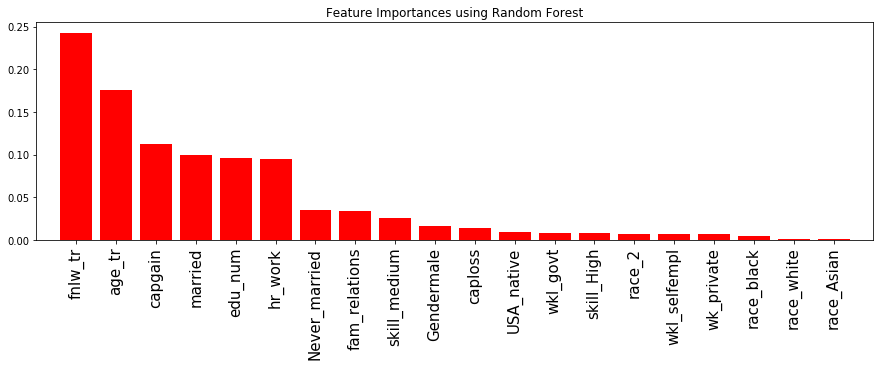

In [100]:
#Plot the graph of feature importances

plt.figure(figsize=(15,4))
plt.title("Feature Importances using Random Forest")
plt.bar(range(X_train.shape[1]),importances[indices],color='r',align='center')
plt.xticks(range(X_train.shape[1]),features[indices],rotation='vertical',fontsize=15)
plt.xlim([-1,X_train.shape[1]])
plt.show()

From the feature importances presented above, it seems only six factors are important for predicting income earnings higher than 50K.  The features include:  fnlwgt, age, capital gain, married, number of years of education, number of hours work per week.  We shall proceed to modelling the income determinants using the six identified variables.

# Building models using the best features as provided by the RandomForestClassifier

In [101]:
#Bulding a confuion matrix function to hold our results:

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,precision_recall_curve

In [102]:
def CMatrix(CM,labels = ['Low','High']):
    df = pd.DataFrame(data=CM,index=labels,columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total']=df.sum()
    df['Total']=df.sum(axis=1)
    return df

In [103]:
#Define the new features based on the significant variables:

Xn_Train = Train[['fnlw_tr','age_tr','capgain','married','edu_num','hr_work','Never_married']]
Xn_Test = Test_dt[['fnlw_tr','age_tr','capgain','married','edu_num','hr_work','Never_married']]
y_train = y_train
y_test = y_test


# Building a DataFrame to hold the results of the various models

The models to built are;  Null, Logistic Regression, Decision Tree, NiaveBayes, Random Forest, Support Vector Machines.

In [104]:
metrics = pd.DataFrame(index=['accuracy','precision','recall'],
                      columns=['NULL','LogisticReg','ClassTree','NaiveBayes','RandomForest','SVMC'])

# The Null Model

In [105]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(),y_test.size)
metrics.loc['accuracy','NULL']=accuracy_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['precision','NULL']=precision_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['recall','NULL']=recall_score(y_pred=y_pred_test,y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
CMatrix(CM)

C:\Users\fobem\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


PREDICTION,Low,High,Total
TRUE,,,
Low,11144,0,11144
High,3493,0,3493
Total,14637,0,14637


# Logistic Regression Model

In [106]:
from sklearn.linear_model import LogisticRegression
LGR = LogisticRegression()
LGR.fit(Xn_Train,y_train)

y_pred_test = LGR.predict(Xn_Test)
metrics.loc['accuracy','LogisticReg']=accuracy_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['precision','LogisticReg']=precision_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['recall','LogisticReg']=recall_score(y_pred=y_pred_test,y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
CMatrix(CM)

C:\Users\fobem\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


PREDICTION,Low,High,Total
TRUE,,,
Low,10316,828,11144
High,1640,1853,3493
Total,11956,2681,14637


# Decision Tree Model

In [107]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(min_samples_split=30,min_samples_leaf=10,random_state=10)
dct.fit(Xn_Train,y_train)

y_pred_test = dct.predict(Xn_Test)
metrics.loc['accuracy','ClassTree']=accuracy_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['precision','ClassTree']=precision_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['recall','ClassTree']=recall_score(y_pred=y_pred_test,y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
CMatrix(CM)

PREDICTION,Low,High,Total
TRUE,,,
Low,10542,602,11144
High,1570,1923,3493
Total,12112,2525,14637


# Naive Bayes Classifier

In [108]:
from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(Xn_Train,y_train)

y_pred_test = NBC.predict(Xn_Test)
metrics.loc['accuracy','NaiveBayes']=accuracy_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['precision','NaiveBayes']=precision_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['recall','NaiveBayes']=recall_score(y_pred=y_pred_test,y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
CMatrix(CM)

PREDICTION,Low,High,Total
TRUE,,,
Low,9142,2002,11144
High,801,2692,3493
Total,9943,4694,14637


# Random Forest Classifier

In [109]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=20,max_depth=None,min_samples_split=7,random_state=0)
RFC.fit(Xn_Train,y_train)

y_pred_test = RFC.predict(Xn_Test)
metrics.loc['accuracy','RandomForest']=accuracy_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['precision','RandomForest']=precision_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['recall','RandomForest']=recall_score(y_pred=y_pred_test,y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
CMatrix(CM)


PREDICTION,Low,High,Total
TRUE,,,
Low,10868,276,11144
High,1113,2380,3493
Total,11981,2656,14637


# Support Vector Machine (SVM)

In [110]:
from sklearn import svm
SVMC = svm.SVC(kernel='linear',C=1)
SVMC.fit(Xn_Train,y_train)

y_pred_test = SVMC.predict(Xn_Test)
metrics.loc['accuracy','SVMC']=accuracy_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['precision','SVMC']=precision_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['recall','SVMC']=recall_score(y_pred=y_pred_test,y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
CMatrix(CM)



PREDICTION,Low,High,Total
TRUE,,,
Low,10317,827,11144
High,1607,1886,3493
Total,11924,2713,14637


In [111]:
100*metrics

,NULL,LogisticReg,ClassTree,NaiveBayes,RandomForest,SVMC
accuracy,76.1358,83.1386,85.1609,80.8499,90.5104,83.3709
precision,0,69.116,76.1584,57.3498,89.6084,69.5171
recall,0,53.049,55.053,77.0684,68.1363,53.9937


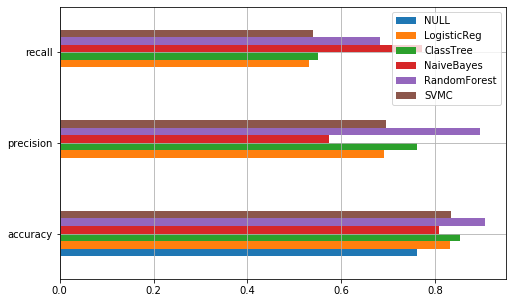

In [112]:
#Plot the graph of the performance of the model

fig,ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh',ax=ax)
ax.grid()

# Adjusting the Recall-Precision curve by modifying the threshold

In [113]:
precision_nb,recall_nb,thresholds_nb = precision_recall_curve(y_true=y_test,probas_pred=NBC.predict_proba(Xn_Test)[:,1])
precision_LR,recall_LR,thresholds_LR = precision_recall_curve(y_true=y_test,probas_pred=LGR.predict_proba(Xn_Test)[:,1])

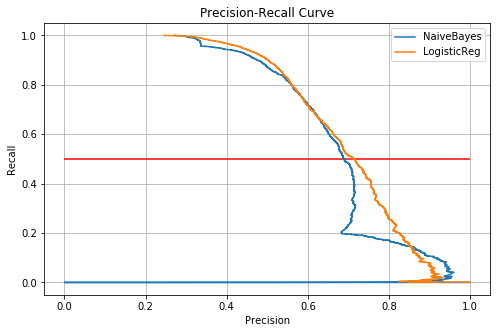

In [114]:
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(precision_nb,recall_nb,label='NaiveBayes')
ax.plot(precision_LR,recall_LR,label='LogisticReg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5,xmin=0,xmax=1,color='red')
ax.legend()
ax.grid()

# Confusion matrix for modified Logistic Regression Classifier

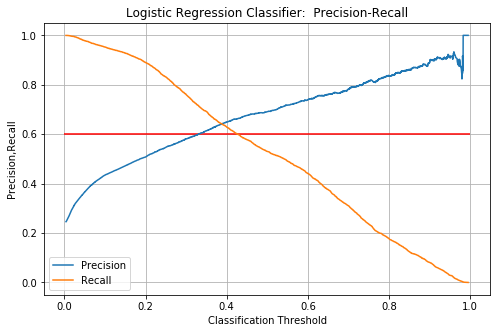

In [115]:
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(thresholds_LR,precision_LR[1:],label='Precision')
ax.plot(thresholds_LR,recall_LR[1:],label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision,Recall')
ax.set_title('Logistic Regression Classifier:  Precision-Recall')
ax.hlines(y=0.6,xmin=0,xmax=1,color='red')
ax.legend()
ax.grid()

When the classification threshold is at 0.2, Recalls performs much better than Precison.  In trying to improve the performance of Recall which is beneficial when the true positives are correclty identified, we can adjust the classification threshold from 0.5 which was the default to 0.2.

# Classifier with threshold of 0.2

In [116]:
y_pred_proba = LGR.predict_proba(Xn_Test)[:,1]
y_pred_test = (y_pred_proba >= 0.2).astype('int')

CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
print('Recall: ',100*recall_score(y_pred=y_pred_test,y_true=y_test))
print('Precision: ',100*precision_score(y_pred=y_pred_test,y_true=y_test))
CMatrix(CM)

Recall:  89.03521328371028
Precision:  50.775510204081634


PREDICTION,Low,High,Total
TRUE,,,
Low,8129,3015,11144
High,383,3110,3493
Total,8512,6125,14637


Recall has now increased from 53% in the Logistic Regression Model to 89% by tunning the classification parameter to 0.2 instead of 0.5